In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
make_notebook_pretty()

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Make initial model

In [5]:
with open("/home/sultan/recipes/exploratory_search-variant2_success.yml", "r") as f:
    yaml_string = f.read()

DATASET_PATH = "/home/sultan/datasets/PScience/PScience.csv"
specific_topics = [f'topic_{i}' for i in range(35)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 1)]

yaml_string = yaml_string.format(
    modality1='@word',
    modality2='@2gramm',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described in the article
# Multi-objective Topic Modeling for Exploratory Search in Tech News
# by Anastasya Yanina, Lev Golitsyn and Konstantin Vorontsov, Jan 2018


# Use .format(modality=modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, in the actuall article 200 topics were found to be optimal
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34']
    background_topics: ['bcg_35']

regularizers:
- DecorrelatorPhiRegularizer:


### Define Topic Model

In [6]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./ExploratoryResearchDemo2') == True:
    os.system("rm -rf ./ExploratoryResearchDemo2")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id='ExploratoryResearchDemo2',
    save_path='ExploratoryResearchDemo2',
)

In [7]:
experiment.run(dataset)

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning_message)
/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Max progression length exceeded
  warnings.warn(warning_message)


{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7fb5c5089128>}

In [8]:
experiment.show()

Experiment ExploratoryResearchDemo2

Experiment was made with BigARTM 0.9.0
Tree:
                              ┌##00h24m37s_25d11m2019y###
                              ├##00h24m54s_25d11m2019y###
                              ├##00h25m11s_25d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>────┤
                              ├##00h25m27s_25d11m2019y###
                              ├##00h25m44s_25d11m2019y###
                              │                                                                                                       ┌##00h26m33s_25d11m2019y###
                              │                                                                                                       ├##00h26m53s_25d11m2019y###
                              └##00h26m01s_25d11m2019y###─────────────────────────────────────────────────────────────────────────────┤
                                                                                                                                      │ 

In [9]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

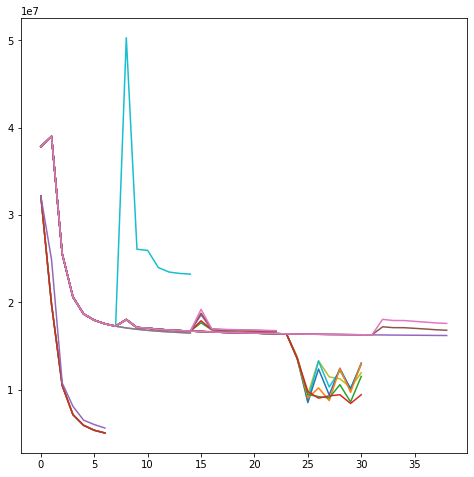

In [10]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:])
plt.show()

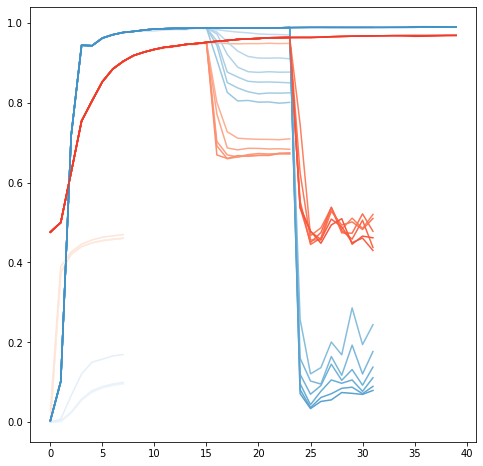

In [11]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
plt.show()

In [12]:
query = (
    "TopicKernel@word.average_contrast > 0.8 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and TopicKernel@word.average_purity > 0.8 * MAXIMUM(TopicKernel@word.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
models = experiment.select(query + " COLLECT all")
def describe_model(model):
    for reg_name, reg in model.regularizers._data.items():
        print(reg_name, reg.tau)
    print(model.scores["PerplexityScore@all"][-1])
    print(model.scores["TopicKernel@word.average_contrast"][-1])
    print(model.scores["TopicKernel@word.average_purity"][-1])
    print("------")
for model in models:
    describe_model(model)

smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
sparse_theta 0
smooth_phi_@word 0
decorrelation_phi_@2gramm 1000000.0
smooth_phi_@2gramm 0
16189898.0
0.9692198634147644
0.9893662333488464
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
sparse_theta 0
smooth_phi_@word 0
decorrelation_phi_@2gramm 1000000.0
smooth_phi_@2gramm 0.25
16791118.0
0.9691254496574402
0.9896120429039001
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
sparse_theta 0
smooth_phi_@word 0
decorrelation_phi_@2gramm 1000000.0
smooth_phi_@2gramm 0.5
17573400.0
0.9686111807823181
0.9902731776237488
------


### Investigate model

In [13]:
best_model = models[-1]

In [14]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw

In [15]:
thresh = 1e-5
demo_data = Dataset(DATASET_PATH)
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [16]:
n=7
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[-n:]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b>", raw=True)

,topic_29 @2gramm
раковый_клетка,0.02645
многоклеточный_организм,0.01621
опухолевый_клетка,0.01472
сигнальный_путь,0.01196
оперативный_память,0.00965
эукариотический_клетка,0.00961
парниковый_эффект,0.0096
глобальный_потепление,0.00894
половый_клетка,0.00838
лечение_рак,0.00745


опухолевые стволовые клетки

изменения генома при раке

наука о клетке

вредные мутации в человеческих популяциях

спермоспецифические белки и онкология

атмосфера венеры

методы лечения рака

ранний и средний протерозой

генетический анализ

faqранний и средний протерозой

,topic_30 @2gramm
российский_империя,0.04223
общественный_благо,0.01569
южный_америка,0.01542
обычный_право,0.01471
речь_посполить,0.0133
северный_америка,0.01086
общественный_пространство,0.00866
тихий_океан,0.00862
публичный_пространство,0.00828
новое_свет,0.00766


национальные меньшинства

коренные народы

кавказский адат

русско-американская колониальная система

теории родового быта

политический ислам

абреки

,topic_31 @2gramm
средний_класс,0.02865
cinema_studies,0.02398
среднее_класс,0.02125
социальный_топология,0.00878
творческий_способность,0.00763
практический_занятие,0.00701
гуманитарный_наука,0.00693
психология_мышление,0.00671
проблемный_ситуация,0.00644
гендерный_исследование,0.00608


средний класс

метод оценки эндотелиальной функции

социальная структура

социальная топология

курс «теория принятия решенийматематические модели выбора»

курс «психология творчествакак рождаются креативные решения»

эндотелиальная клетка

курс «основы молекулярной биологии»

компьютерные доказательства

статусы гуманитарной науки

,topic_32 @2gramm
нейтронный_звезда,0.10693
белый_карлик,0.02357
белых_карлик,0.02325
компактный_объект,0.01992
белые_карлик,0.01408
термоядерный_реакция,0.01191
химический_элемент,0.00847
кварковый_звезда,0.00756
рентгеновский_луч,0.00748
магнитный_поль,0.00729


пограничные слои вблизи компактных объектов

рентгеновское небо

великое объединение нейтронных звезд

ударные волны вблизи компактных объектов

компактные звезды

эволюция нейтронных звезд

физика атмосфер нейтронных звезд

недра нейтронных звезд

рентгеновская астрономия

обнаружена самая яркая нейтронная звезда

,topic_33 @2gramm
средний_век,0.0297
политический_философия,0.02194
xiii_век,0.02123
xii_век,0.01853
политический_теория,0.01259
фома_аквинский,0.01042
германский_язык,0.0104
священный_писание,0.01007
iii_век,0.01005
политический_мысль,0.00942


позитивная философия науки

памятники классического периода истории древнего китая

современная аналитическая философия

политическая теория эмоций

история политической мысли древнего мира и средних веков

понятия власти в средневековой политической теории

новейшая история египта

молекулярные машины

политическая мысль схоластики xii века

средневековые ведовские процессы

,topic_34 @2gramm
органический_химия,0.021
новый_программа,0.01866
магнитный_поль,0.01192
метод_лечение,0.01055
магнитный_пол,0.01021
магнитный_момент,0.00973
метод_ямр,0.00959
следовать_ждать,0.00931
научный_сообщество,0.00824
магнитный_буря,0.00776


космическая погода

перспективыдоказательная медицина

перспективыфилософия массовой культуры

перспективысоциология академической жизни

гелиосейсмология

мертвые языки

перспективыбыть астрофизиком

перспективыфеномен фэнтези

перспективыфизика на коллайдерах

магнитные наночастицы

,bcg_35 @2gramm
речь_идти,0.0075
крайний_мера,0.00661
xx_век,0.00623
xix_век,0.00622
дать_случай,0.00586
мировой_война,0.00509
большой_количество,0.0049
огромный_количество,0.00468
друг_друг,0.00422
конец_конец,0.00407


борьба эллинофилов и мизэллинов

алмазное правило этики

фальсификация экспертности

главы #болезни и смертность

теория речевых актов

инвазионная биология

модель квазивидов

исследовательские программы в экологии

гипотеза лингвистической относительности

экономика обмана

In [17]:
print(doc_id)

2857.txt


In [18]:
from topicnet.viewers import TopSimilarDocumentsViewer

In [19]:
tsdv = TopSimilarDocumentsViewer(best_model, dataset)

In [31]:
search_doc = '174.txt'
print(dataset.get_source_document(search_doc)['raw_text'].values)
sim_docs, scores = tsdv.view(
    search_doc,
    metric='euclidean',
    num_top_similar=10)
for doc_id in sim_docs:
    document = dataset.get_source_document(doc_id)
    doc_title = document.index.values[0]
    doc_snippet = '.'.join(document['raw_text'].values[0].split('.')[:3])
    display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

['@title Геоморфология | @snippet Географ Андрей Лукашов о датировке рельефа, динамической геоморфологии и угрозе землетрясений\n']


2504.txt @title Строение языка | @snippet Лингвист Ноам Хомский о синтаксисе естественных языков и принципах человеческого мышления, сходных со свойствами снежинки

463.txt @title Полевая лингвистика | @snippet Лингвист Владимир Плунгян о практике полевых экспедиций, многообразии человеческих языков и двух типах лингвистов

2316.txt @title Прикладная лингвистика | @snippet Лингвист Анатолий Баранов о грамматической теории Зализняка, программах проверки орфографии и упрощении языка законов

195.txt @title Частоты значений слов | @snippet Лингвист Анастасия Лопухина о «Случае с Оливером», частотных словарях русского языка и способах подсчета частоты значения слова

1619.txt @title ScienceHub #08: Нейроинтерфейсы | @snippet Психофизиолог Александр Каплан о расшифровке активности мозга, его содержании и взаимодействии между мозгом и внешним устройством

521.txt @title FAQ: Технология мысли | @snippet 5 фактов о строении мозга человека, принципах его работы и уникальных функциях

1941.txt @title Что такое «китайская комната»? | @snippet Философ Дмитрий Иванов о ментальных состояниях, аргументе Джона Сёрла против функционализма и сильном искусственном интеллекте

989.txt @title FAQ: Нейрокоммуникаторы | @snippet 7 фактов о новой модели коммуникации между человеком и средой

3117.txt @title Экспериментальная лингвистика | @snippet Лингвист Мария Полински о поведенческих подходах, обобщающих местоимениях и гендерных аспектах в различных языках

552.txt @title Компьютерные корпуса устной речи | @snippet Лингвист Вера Подлесская о компьютерных анализаторах речи, устной коммуникации и бесписьменных языках